# k-Nearest Neighbors

El método de k-Nearest Neighbors (kNN) de _clasificación_ se basa en no asumir ninguna forma particular del conjunto de datos y las características que presentan.
Se hacen algunas hipótesis correspondientes para crear un modelo, pero lo importante de estos métodos es que pueden generalizar _sin conocer_ la estructura de los datos.

## Teoría probabilística del método

El método de kNN asume que el conjunto de datos proviene de una distribución de probabilidad _suave_ tal que la densidad de probabilidad $p(\mathbf{x})$ puede ser determinada en un punto $\mathbf{x}$ particular, dentro de una pequeña región $R$ con volumen $V$ y centrada en $\mathbf{x}$ según la expresión

$$p(\mathbf{x}) V \approx \int_R p(\mathbf{u}) d \mathbf{u} .$$

Siguiendo esta expresión, se puede estimar la **pdf** o **función de densidad de probabilidad** mediante la fórmula

$$ \hat{p} \left( \mathbf{x} \right) \approx \frac{k / n}{V} ,$$

donde en el caso de la clasificación corresponde a tener $n$ **patrones** y $k$ de ellos caen dentro del **volumen** *V.*
Para el algoritmo **kNN** el objetivo es fijar $k$ tal que sólamente se aumente el volumen para tener los $k$ patrones dentro de $V$ y se calcula la probabilidad
correspondiente.

El **algoritmo** es como sigue:

1. El conjunto de entrenamiento son todos los datos, y deben estar **clasificados.**
2. Usando alguna *métrica* en particular se calcula la distancia de un punto a *clasificar* a sus $k$ vecinos.
3. La distancia más corta es la clase a la que pertenece ese punto a *clasificar*.
4. Cuando $k > 1$ entonces se debe emplear la siguinte decisión: la mayor cantidad de puntos pertenecientes a esa clase
   son a la que pertence ese punto a *clasificar*; ejemplo: si $k = 2$ y hay un punto por cada patrón, el de menor distancia
   es al que pertence, pero cuando $k = 3$ y hay 2 de un patrón y 1 de otro patrón, el punto a clasificar pertence a la clase
   de los dos puntos más cercanos.

## Complejidad algorítmica

Supóngase que se tienen __n__ muestras de dimensión **d** (i.e. el número de patrones), su complejidad es:

- __O(d)__ para calcular la distancia a una sola muestra.
- __O(nd)__ para calcular la distancia a todas las *n* muestras y encontrar el primer vecino más cercano.
- __O(knd)__ para calcular la distancia a todas las *n* muestras y encontrar la mínima distancia a los *k* vecinos más cercanos.

El análisis de la complejidad es fundamental en este escenario pues calcular distancias y encontrar los vecinos más cercanos es un problema abierto en
la Ciencia de la Computación. El análisis presentado aquí corresponde a emplear la técnica de _fuerza bruta_ para calcular los vecinos más cercanos,
sin embargo, en la implementación que se presenta en este documento se emplean estructuras de datos más eficientes como el _kd tree_; para más
información visitar las referencias al final de este documento.

Adicionalmente, el problema de buscar vecinos más cercanos en dimensiones muy altas es un también un problema abierto de investigación. En estos espacios
de muchas características $> 10^5$ los árboles de búsqueda no funcionan, o son demasiado lentos, por lo que se tienen que emplear diferentes estructuras
o nuevos algoritmos.

## Una nota sobre las métricas espaciales

En este caso se asume que se está trabajando en un espacio Euclidiano donde la métrica está definida como

$$\lVert x - y \rVert_2 = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$$

lo que corresponde a la distancia entre el punto $x$ y el punto $y$. Sin embargo este no siempre es el caso pues existen muchas métricas según el espacio
en el que se esté trabajando. Esto es importante de mencionar porque las estructuras de búsqueda deben modificarse acorde al espacio, no se puede trabajar
siempre con las mismas estructuras; en la sección de referencias se presentan dos ejemplos de esto.

In [12]:
# Modificar el tamaño de las figuras
import matplotlib

matplotlib.rcParams["figure.figsize"] = (21, 12)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

sns.set()

In [13]:
# Crear algunos datos/clases de entrenamiento
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    n_classes=3,
    random_state=20,
)

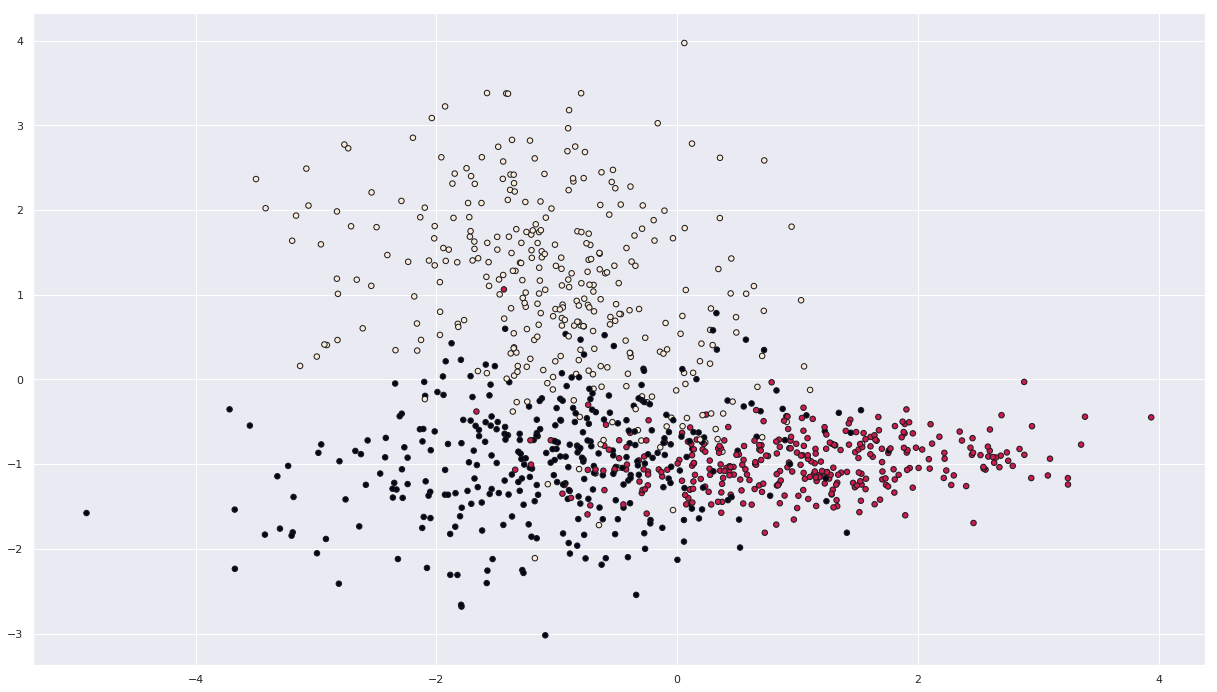

In [14]:
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=30, edgecolor="k")

Es importante analizar por un momento esta figura. Una de las ventajas del método kNN es clasificar cuando existe mucho ruido entre los datos. Observando la figura anterior es fácil de ver que las 3 clases están una sobra la otra, no existe una separación _lineal_ visible, ni existe una forma simple de discernir entre una clase u otra.

In [15]:
# Implementación propia, empleand kd-tree para la búsqueda de vecinos más cercanos
from scipy.spatial import KDTree


class kNearestNeighbors:
    def __init__(self, num_vecinos=3):
        self.kd_tree = None
        self.kn = num_vecinos
        self.dicc_probabilidades = dict()
        self.etiquetas = None

    def entrenamiento(self, datos, clases):
        # Inicializar el árbol de búsqueda
        self.kd_tree = KDTree(datos)
        # Inicializar el diccionario de probabilidades
        for i in list(set(clases)):
            self.dicc_probabilidades[i] = 0

        # Guardar las etiquetas
        self.etiquetas = clases

    def predecir(self, datos):
        resultado = np.zeros(datos.shape[0])

        for n, d in enumerate(datos):
            __, indices = self.kd_tree.query(d, k=self.kn)

            for k in self.dicc_probabilidades.keys():
                for i, j in enumerate(self.etiquetas):
                    for l in indices:
                        # Si el índice es el mismo
                        if i == l:
                            # Y son de la misma clase
                            if j == k:
                                self.dicc_probabilidades[k] += 1

            for i, j in self.dicc_probabilidades.items():
                self.dicc_probabilidades[i] = j / self.kn

            # Siempre se devuelve la mayor probabilidad encontrada entre todas las clases
            resultado[n] = max(
                self.dicc_probabilidades, key=self.dicc_probabilidades.get
            )

            # Reinicar el diccionario de probabilidades
            for i in list(set(self.etiquetas)):
                self.dicc_probabilidades[i] = 0

        return resultado

In [16]:
# Separar el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=35
)

In [17]:
# Crear una instancia del clasificador implementado
clf_knn = kNearestNeighbors(num_vecinos=5)
# Entrenar para crear el árbol de búsqueda
clf_knn.entrenamiento(X_train, y_train)
# Finalmente obtener las clases correspondientes
resultado = clf_knn.predecir(X_test)

In [18]:
matr_conf = confusion_matrix(y_test, resultado)
print("Matriz de Confusión")
print(matr_conf)
print("Reporte de Clasificación")
print(classification_report(y_test, resultado))

Matriz de Confusión
[[88 11  4]
 [18 79  0]
 [14  3 83]]
Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       103
           1       0.85      0.81      0.83        97
           2       0.95      0.83      0.89       100

   micro avg       0.83      0.83      0.83       300
   macro avg       0.85      0.83      0.84       300
weighted avg       0.84      0.83      0.84       300



## Implementación de `scikit-learn`

En esta sección que sigue se utiliza la implementación de la librería `scikit-learn` que se puede ingresar desde [aquí](https://scikit-learn.org/stable/modules/neighbors.html#classification).
Esta implementación contiene más funciones, está habilitada para cómputo paralelo y sobre todo se pueden emplear más _métricas_ que la utilizada en esta implementación, lo cual es muy útil cuando la clasificación no solamente es de valores numéricos sino de texto o cualquier otro tipo de variables categóricas.

In [19]:
# Instanciar el clasificador, entrenarlo y predecir
clfd = KNeighborsClassifier(5)
clfd.fit(X_train, y_train)
resultado = clfd.predict(X_test)

In [20]:
# Matriz de confusión y reporte
matr_conf = confusion_matrix(y_test, resultado)
print("Matriz de Confusión")
print(matr_conf)
print("Reporte de Clasificación")
print(classification_report(y_test, resultado))

Matriz de Confusión
[[88 11  4]
 [18 79  0]
 [14  3 83]]
Reporte de Clasificación
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       103
           1       0.85      0.81      0.83        97
           2       0.95      0.83      0.89       100

   micro avg       0.83      0.83      0.83       300
   macro avg       0.85      0.83      0.84       300
weighted avg       0.84      0.83      0.84       300



Es interesante notar que la implementación propuesta y la implementación de `scikit-learn` devuelven resultados iguales. Esto es porque se está empleando la misma estructura de búsqueda en ambos casos, adicionalmente de que no hay opciones de métricas diferentes.

In [21]:
# Tomado de scikit-learn: https://tinyurl.com/yawodqj5
# Este código grafica la matriz de confusión para que sea más fácil de visualizar
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="Etiqueta real",
        xlabel="Etiqueta predicción",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.tight_layout()

    return ax


Confusion matrix, without normalization
[[88 11  4]
 [18 79  0]
 [14  3 83]]


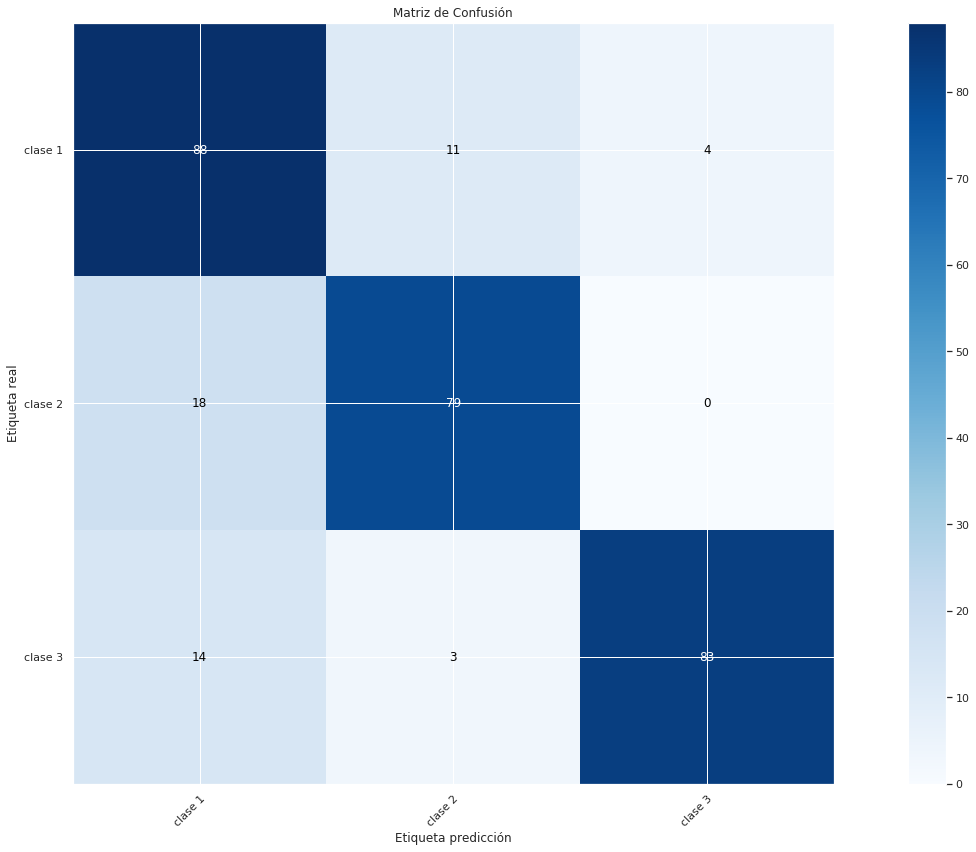

In [22]:
# Graficar la matriz de confusión con el nombre de cada clase
nombres_clases = np.array(["clase 1", "clase 2", "clase 3"])
plot_confusion_matrix(
    y_test, resultado, classes=nombres_clases, title="Matriz de Confusión"
)


Ahora que se graficó la matriz de confusión se puede observar que el clasificador propuesto tiene un buen desempeño. Esto se puede ver por los colores que toma la diagonal de la matriz de confusión, entre más intenso el color mejor es la clasificación. Claramente existen algunos errores de clasificación que podrían ser modificados o resueltos empleando técnicas más complejas y avanzadas, o manipulando mejor los datos.

## Referencias

1. [Implementación de kd-tree.](http://www.cs.umd.edu/~mount/Papers/cgc99-smpack.pdf)

2. [Estructuras de búsquedas para datos con dimensiones muy altas.](http://people.ee.duke.edu/~lcarin/liu06a.pdf)

3. [_Pattern Recognition._ Marques de Sa, J.P.](https://books.google.com.mx/books?id=CtipCAAAQBAJ&dq=inauthor:%22J.P.+Marques+de+S%C3%A1%22&hl=es&source=gbs_navlinks_s)